## Lectures

### Introduction to *Blue Book for Bulldozers*

Blue Book for Bulldozers Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very common type of dataset and prediciton problem, and similar to what you may see in your project or workplace.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn.tree import DecisionTreeRegressor

from sklearn import metrics
import pandas as pd
import numpy as np
from structured import *

/anaconda3/envs/data-science/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "data/"

In [4]:
!ls {PATH}

Test.csv          Train.zip         Valid.csv         ValidSolution.csv
Train.csv         TrainAndValid.csv Valid.zip


### The data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

*Question*

What stands out to you from the above description?  What needs to be true of our training and validation sets?

`pandas` is the most important library when you are working with structured data which is usually imported as `pd`.

In [5]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

* `parse_dates`  —  A list of any columns that contain dates
* `low_memory=False`  —  Forces it to read more of the file to decide what the types are.

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [6]:
df_raw.shape

(401125, 53)

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 5, "display.max_columns", 10): 
        display(df)

In [8]:
display_all(df_raw.tail().T)

401120   401121   401122   401123   401124
SalesID            6333336  6333337  6333338  6333341  6333342
SalePrice            10500    11000    11500     9000     7750
...                    ...      ...      ...      ...      ...
Differential_Type      NaN      NaN      NaN      NaN      NaN
Steering_Controls      NaN      NaN      NaN      NaN      NaN

[53 rows x 5 columns]

In [9]:
display_all(df_raw.describe(include='all').T)

count unique           top   freq first  ...          min  \
SalesID            401125    NaN           NaN    NaN   NaT  ...  1.13925e+06   
SalePrice          401125    NaN           NaN    NaN   NaT  ...         4750   
...                   ...    ...           ...    ...   ...  ...          ...   
Differential_Type   69411      4      Standard  68073   NaT  ...          NaN   
Steering_Controls   69369      5  Conventional  68679   NaT  ...          NaN   

                           25%          50%          75%          max  
SalesID            1.41837e+06  1.63942e+06  2.24271e+06  6.33334e+06  
SalePrice                14500        24000        40000       142000  
...                        ...          ...          ...          ...  
Differential_Type          NaN          NaN          NaN          NaN  
Steering_Controls          NaN          NaN          NaN          NaN  

[53 rows x 13 columns]

The variable we want to predict is called *Dependent Variable* in this case our dependent variable is `SalePrice`.

It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [10]:
    df_raw.SalePrice = np.log(df_raw.SalePrice)

### Machine Learning - Linear Regresion

Everything in *scikit-learn* has the same form.

* Create an instance of an object for the machine learning model
* Call `fit` by passing in the independent variables (the things you are going to use to predict) and dependent variable (the thing you want to predict).
* `axis=1` means remove columns.
* shift + tab in Jupyter Notebook will bring up the inspection of the parameters of a function.
* `“list-like”` means anything you can index in Python.

In [11]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

m = LinearRegression().fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)
#m.score(X_valid, y_valid)

ValueError: could not convert string to float: 'Low'

### Data Pre-processing

The above code will result in an error. There was a value inside the dataset “Conventional”, and it did not know how to create a model using that String. We have to pass numbers to most machine learning models and certainly to random forests. So step 1 is to convert everything into numbers.

This dataset contains a mix of **continuous** and **categorical** variables.

**continuous** — numbers where the meaning is numeric such as price.
categorical — either numbers where the meaning is not continuous like zip code or string such as “large”, “medium”, “small”
Here are some of the information we can extract from date — year, month, quarter, day of month, day of week, week of year, is it a holiday? weekend? was it raining? was there a sport event that day? It really depends on what you are doing. If you are predicting soda sales in SoMa, you would probably want to know if there was a San Francisco Giants ball game that day. What is in a date is one of the most important piece of feature engineering you can do and no machine learning algorithm can tell you whether the Giants were playing that day and that it was important. So this is where you need to do feature engineering.

The `add_datepart` method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can’t capture any trend/cyclical behavior as a function of time at any of these granularities.

In [12]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [13]:
display_all(df_raw.describe(include='all').T)

count unique    top    freq         mean  ...  \
SalesID            401125    NaN    NaN     NaN  1.91971e+06  ...   
SalePrice          401125    NaN    NaN     NaN      10.1031  ...   
...                   ...    ...    ...     ...          ...  ...   
saleIs_year_start  401125      1  False  401125          NaN  ...   
saleElapsed        401125    NaN    NaN     NaN  1.09143e+09  ...   

                           min          25%          50%          75%  \
SalesID            1.13925e+06  1.41837e+06  1.63942e+06  2.24271e+06   
SalePrice               8.4659       9.5819      10.0858      10.5966   
...                        ...          ...          ...          ...   
saleIs_year_start          NaN          NaN          NaN          NaN   
saleElapsed        6.00998e+08  9.70877e+08  1.14307e+09  1.23785e+09   

                           max  
SalesID            6.33334e+06  
SalePrice              11.8636  
...                        ...  
saleIs_year_start          NaN  
saleElapsed         1.3252e+09  

[65 rows x 11 columns]

After running `add_datepart`, it added many numerical columns and removed `saledate` column. This is not quite enough to get passed the error we saw earlier as we still have other columns that contain string values. Pandas has a concept of a category data type, but by default it would not turn anything into a category for you. `train_cats` creates categorical variables for everything that is a String. Behind the scenes, it creates a column that is an integer and it is going to store a mapping from the integers to the strings. `train_cats` is called “train” because it is training data specific. It is important that validation and test sets will use the same category mappings (in other words, if you used 1 for “high” for a training dataset, then 1 should also be for “high” in validation and test datasets). For validation and test dataset, use apply_cats instead.



The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [14]:
train_cats(df_raw)

In [15]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

The order does not matter too much, but since we are going to be creating a decision tree that split things at a single point (i.e. `High` vs. `Low` and `Medium` , `High` and `Low` vs. `Medium` ) which is a little bit weird. To order them in a sensible manner, you can do the following:

In [16]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

`inplace` will ask Pandas to change the existing dataframe rather than returning a new one.

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [17]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [18]:
print(df_raw.UsageBand)

0         2
1         2
2         0
3         0
4         1
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Name: UsageBand, Length: 401125, dtype: int8


We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a decision tree.

In [19]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting    0.803872
Blade_Extension     0.937129
                      ...   
saleYear            0.000000
state               0.000000
Length: 65, dtype: float64

### Continue to pre-process data

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [20]:
df, y, nas = proc_df(df_raw, 'SalePrice')

* `df` — data frame
* `y_fld` — name of the dependent variable
* It makes a copy of the data frame, grab the dependent variable values `(y_fld)`, and drop the dependent variable from the data frame.
* Then it will `fix_missing` (see below)
* We then will go through the data frame and call `numericalize` (see below).
* `dummies` — There are columns with a small number of possible values, you can put into dummies instead of numericalizing them. But we will not do that for now.

`fix_missing`
* For numeric data type, first we check if there is null column. If so, it will create a new column with a name with `_na` appended at the end and set it to 1 if it is missing; 0 otherwise (boolean). It will then replace the missing value with a median.
* We do not need to do this for categorical variables because Pandas handles them automatically by setting them to `-1`.


`numericalize`
If it is not numeric and is a categorical type, we will replace the column with its code plus 1. By default pandas uses -1 for missing, so now missing will have an ID of 0 .

In [21]:
df.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246     999089     3157         121           3.0      2004   
1  1139248     117657       77         121           3.0      1996   
2  1139249     434808     7009         121           3.0      2001   
3  1139251    1026470      332         121           3.0      2001   
4  1139253    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                      68.0          2          950          296  ...   
1                    4640.0          2         1725          527  ...   
2                    2838.0          0          331          110  ...   
3                    3486.0          0         3674         1375  ...   
4                     722.0          1         4208         1529  ...   

   saleDayofyear  saleIs_month_end  saleIs_month_start  saleIs_quarter_end  \
0            320             False               False               False   
1             86             False               False               False   
2             57             False               False               False   
3            139             False               False               False   
4            204             False               False               False   

   saleIs_quarter_start  saleIs_year_end  saleIs_year_start  saleElapsed  \
0                 False            False              False   1163635200   
1                 False            False              False   1080259200   
2                 False            False              False   1077753600   
3                 False            False              False   1305763200   
4                 False            False              False   1248307200   

   auctioneerID_na  MachineHoursCurrentMeter_na  
0            False                        False  
1            False                        False  
2            False                        False  
3            False                        False  
4            False                        False  

[5 rows x 66 columns]

Now we have all numerical values. Note that booleans are treated as numbers. So we can create a decision tree.

In [22]:
# Note: change max_depth
tree = DecisionTreeRegressor(max_depth=15)
tree.fit(df, y)
tree.score(df,y)

0.8965143764654961

In [23]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 120000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((281125, 66), (281125,), (120000, 66), (120000,))

## Base model

Let's try our model again, this time with separate training and validation sets.

In [24]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Another way to split data

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df,
    y,
    test_size=0.25,
    random_state=42,
)

## Linear Regression

In [26]:
df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [27]:
df, y, nas, mapper = proc_df(df_raw, 'SalePrice', max_n_cat=10, do_scale=True)

In [28]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df)-n_valid
y_train, y_valid = split_vals(y, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [29]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

### Check data after scaling

In [30]:
df.describe().transpose()

count          mean       std  \
SalesID                                401125.0  1.451110e-16  1.000001   
MachineID                              401125.0 -2.879547e-16  1.000001   
ModelID                                401125.0 -5.895135e-17  1.000001   
datasource                             401125.0  7.164857e-16  1.000001   
auctioneerID                           401125.0 -4.959850e-18  1.000001   
...                                         ...           ...       ...   
Steering_Controls_Conventional         401125.0  1.712160e-01  0.376698   
Steering_Controls_Four Wheel Standard  401125.0  3.440324e-04  0.018545   
Steering_Controls_No                   401125.0  2.492988e-06  0.001579   
Steering_Controls_Wheel                401125.0  3.490184e-05  0.005908   
Steering_Controls_nan                  401125.0  8.270639e-01  0.378193   

                                            min       25%       50%       75%  \
SalesID                               -0.858580 -0.551518 -0.308344  0.355322   
MachineID                             -2.761738 -0.292989  0.139657  0.567277   
ModelID                               -1.102854 -0.583548 -0.367372  0.294819   
datasource                            -1.524823 -0.297450 -0.297450  0.148868   
auctioneerID                          -0.381738 -0.321407 -0.261075 -0.140412   
...                                         ...       ...       ...       ...   
Steering_Controls_Conventional         0.000000  0.000000  0.000000  0.000000   
Steering_Controls_Four Wheel Standard  0.000000  0.000000  0.000000  0.000000   
Steering_Controls_No                   0.000000  0.000000  0.000000  0.000000   
Steering_Controls_Wheel                0.000000  0.000000  0.000000  0.000000   
Steering_Controls_nan                  0.000000  1.000000  1.000000  1.000000   

                                            max  
SalesID                                4.855369  
MachineID                              2.876309  
ModelID                                4.871330  
datasource                             4.165727  
auctioneerID                           5.591096  
...                                         ...  
Steering_Controls_Conventional         1.000000  
Steering_Controls_Four Wheel Standard  1.000000  
Steering_Controls_No                   1.000000  
Steering_Controls_Wheel                1.000000  
Steering_Controls_nan                  1.000000  

[189 rows x 8 columns]

In [31]:
X_train, X_valid = split_vals(df, n_trn)

In [32]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

m = LinearRegression().fit(X_train, y_train)
m.score(X_valid, y_valid)

0.2454498519126926

In [33]:
m.score(X_train, y_train)

0.6085979708910523

In [34]:
preds = m.predict(X_valid)

In [35]:
rmse(preds, y_valid)

0.6500100438523817

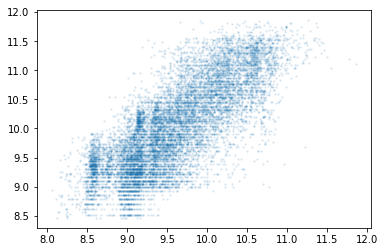

In [36]:
# Scatter plot
plt.scatter(preds, y_valid, alpha=0.1, s=2);

### Reference
1. fastai.com (http://course.fast.ai/ml.html)
2. https://medium.com/@hiromi_suenaga/machine-learning-1-lesson-1-84a1dc2b5236
3. https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/
